In [1]:
import numpy as np
import sys
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import math
import seaborn as sns
import matplotlib

### Loading the data

In [2]:
def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def load_data(dataset):
    # load the data: x, tx, allx, graph
    names = ['x', 'tx', 'allx', 'graph']
    objects = []
    for i in range(len(names)):
        with open("../citeseer/data/ind.{}.{}".format(dataset, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))
    x, tx, allx, graph = tuple(objects)
    test_idx_reorder = parse_index_file("../citeseer/data/ind.{}.test.index".format(dataset))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    return adj, features

def load_data_2(dataset): #Includes fixing isolated nodes for y
    
    # load the data: x, tx, allx, graph
    dataset = 'citeseer'
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("../data/citeseer/ind.{}.{}".format(dataset, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))
    
    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("../data/citeseer/ind.{}.test.index".format(dataset))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)

        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        ty_extended = sp.lil_matrix((len(test_idx_range_full), y.shape[1]))

        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        ty_extended[test_idx_range-min(test_idx_range), :] = ty

        tx = tx_extended
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    y        = sp.vstack((ally, ty)).tolil()
    
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    
    return adj, features, ty, y
    
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)


In [4]:
adj, features, ty, y = load_data_2('citeseer')

In [5]:
adj.shape

(3327, 3327)

In [6]:
features.shape

(3327, 3703)

### Running the model

In [6]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score


sys.path.append('../')

from optimizer import OptimizerAE, OptimizerVAE
from input_data import load_data
from model import GCNModelAE, GCNModelVAE
from preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges


# Settings

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
#flags.DEFINE_integer('hidden3', 2, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', 'gcn_ae', 'Model string.')
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')
flags.DEFINE_integer('features', 1, 'Whether to use features (1) or not (0).')

flags.DEFINE_string('f', '', 'kernel')

#model_str = FLAGS.model
#dataset_str = FLAGS.dataset

model_str = 'gcn_vae'
dataset_str = 'citeseer'



# Load data
adj, features, ty, y = load_data_2(dataset_str)

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

if FLAGS.features == 0:
    features = sp.identity(features.shape[0])  # featureless

# Some preprocessing
adj_norm = preprocess_graph(adj)

# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

num_nodes = adj.shape[0]

features = sparse_to_tuple(features.tocoo())
num_features = features[2][1]
features_nonzero = features[1].shape[0]

# Create model
model = None
if model_str == 'gcn_ae':
    model = GCNModelAE(placeholders, num_features, features_nonzero)
elif model_str == 'gcn_vae':
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

# Optimizer
with tf.name_scope('optimizer'):
    if model_str == 'gcn_ae':
        opt = OptimizerAE(preds=model.reconstructions,
                          labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                      validate_indices=False), [-1]),
                          pos_weight=pos_weight,
                          norm=norm)
    elif model_str == 'gcn_vae':
        opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm)

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

cost_val = []
acc_val = []


def get_roc_score(edges_pos, edges_neg, emb=None):
    
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score, emb, labels_all


cost_val = []
acc_val = []
val_roc_score = []

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    roc_curr, ap_curr, emb, labels_all = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

roc_score, ap_score, emb, labels_all = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
targets is deprecated, use labels instead

Epoch: 0001 train_loss= 1.80352 train_acc= 0.49672 val_roc= 0.66980 val_ap= 0.68875 time= 3.63610
Epoch: 0002 train_loss= 1.37954 train_acc= 0.44384 val_roc= 0.68655 val_ap= 0.70912 time= 0.63005
Epoch: 0003 train_loss= 1.18615 train_acc= 0.32413 val_roc= 0.70776 val_ap= 0.73421 time= 0.74359
Epoch: 0004 train_loss= 1.02594 train_acc= 0.34133 val_roc= 0.74383 val_ap= 0.76467 time= 0.52806
Epoch: 0005 train_loss= 0.92664 train_acc= 0.35896 val_roc= 0.78599 val_ap= 0.80079 time= 0.61654
Epoch: 0006 train_loss= 0.81795 train_acc= 0.34805 val_roc= 0.82604 val_ap= 0.83893 time= 0.62547
Epoch: 0007 train_loss= 0.73407 train_acc= 0.36311 val_roc= 0.82724 val_ap= 0.84974 time= 0.64627
Epoch: 0008 train_loss= 0.6767

Epoch: 0065 train_loss= 0.44533 train_acc= 0.52683 val_roc= 0.91488 val_ap= 0.92629 time= 0.62922
Epoch: 0066 train_loss= 0.44474 train_acc= 0.52668 val_roc= 0.91455 val_ap= 0.92596 time= 0.59626
Epoch: 0067 train_loss= 0.44416 train_acc= 0.52730 val_roc= 0.91448 val_ap= 0.92556 time= 0.59171
Epoch: 0068 train_loss= 0.44372 train_acc= 0.52766 val_roc= 0.91469 val_ap= 0.92566 time= 0.59933
Epoch: 0069 train_loss= 0.44352 train_acc= 0.52752 val_roc= 0.91482 val_ap= 0.92550 time= 0.59943
Epoch: 0070 train_loss= 0.44322 train_acc= 0.52798 val_roc= 0.91529 val_ap= 0.92563 time= 0.63099
Epoch: 0071 train_loss= 0.44314 train_acc= 0.52847 val_roc= 0.91543 val_ap= 0.92520 time= 0.59268
Epoch: 0072 train_loss= 0.44250 train_acc= 0.52888 val_roc= 0.91543 val_ap= 0.92469 time= 0.62602
Epoch: 0073 train_loss= 0.44184 train_acc= 0.52874 val_roc= 0.91527 val_ap= 0.92443 time= 0.57493
Epoch: 0074 train_loss= 0.44189 train_acc= 0.52816 val_roc= 0.91484 val_ap= 0.92386 time= 0.59650
Epoch: 0075 train_lo

Epoch: 0149 train_loss= 0.43405 train_acc= 0.53818 val_roc= 0.91164 val_ap= 0.91584 time= 0.75211
Epoch: 0150 train_loss= 0.43394 train_acc= 0.53845 val_roc= 0.91164 val_ap= 0.91542 time= 0.57789
Epoch: 0151 train_loss= 0.43403 train_acc= 0.53851 val_roc= 0.91182 val_ap= 0.91630 time= 0.68387
Epoch: 0152 train_loss= 0.43384 train_acc= 0.53761 val_roc= 0.91154 val_ap= 0.91633 time= 0.55999
Epoch: 0153 train_loss= 0.43412 train_acc= 0.53722 val_roc= 0.91071 val_ap= 0.91476 time= 0.70093
Epoch: 0154 train_loss= 0.43377 train_acc= 0.53843 val_roc= 0.91147 val_ap= 0.91532 time= 0.63281
Epoch: 0155 train_loss= 0.43393 train_acc= 0.53790 val_roc= 0.91195 val_ap= 0.91674 time= 0.61876
Epoch: 0156 train_loss= 0.43373 train_acc= 0.53825 val_roc= 0.91160 val_ap= 0.91650 time= 0.61929
Epoch: 0157 train_loss= 0.43362 train_acc= 0.53841 val_roc= 0.91114 val_ap= 0.91556 time= 0.63693
Epoch: 0158 train_loss= 0.43363 train_acc= 0.53951 val_roc= 0.91087 val_ap= 0.91587 time= 0.60474
Epoch: 0159 train_lo

In [15]:
roc_score

0.9263663808718754

### Playing with Embeddings

In [16]:
emb.shape

(3327, 16)

In [17]:
X_embedded = TSNE(n_components=2,  perplexity = 6).fit_transform(emb)
y_onehot = y.todense()
y_list = np.argmax(y_onehot, axis=1)
y_list = [i[0] for i in y_list.tolist()]
conference_labels = ['Agents', 'AI', 'DB', 'IR', 'ML', 'HCI']
plot_labels = [conference_labels[i] for i in y_list]
plot_df = pd.DataFrame({'x0': X_embedded[:,0], 'x1': X_embedded[:,1], 'y': y_list, 'y_label': plot_labels})

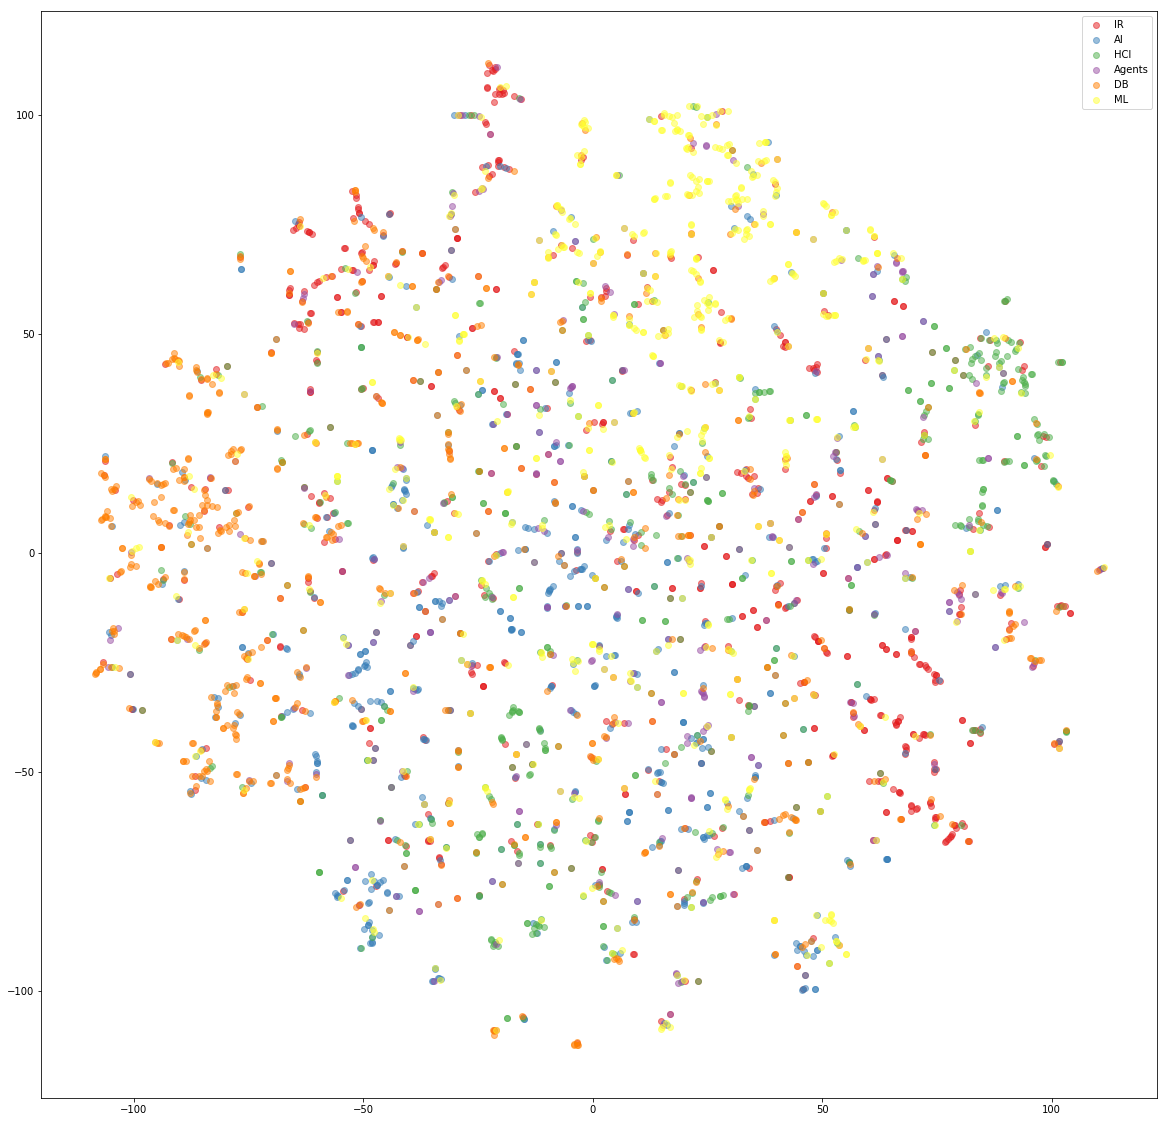

In [19]:
plt.figure(figsize = (20, 20))
colors = plt.cm.get_cmap('Set1').colors

for i, label in enumerate(plot_df['y_label'].unique()):

    colors      = plt.cm.get_cmap('Set1').colors
    plot_df_sub = plot_df.loc[plot_df['y_label'] == label]
    
    plt.scatter(plot_df_sub['x0'], plot_df_sub['x1'], c = matplotlib.colors.to_hex(colors[i]),
                alpha = 0.5, cmap = cm.hsv, label = label)

plt.legend()

In [36]:
adj_rec = np.dot(emb, emb.T)

In [42]:
adj_rec.shape

(3327, 3327)

In [14]:
emb.shape

(3327, 16)

## Attempting to modify Embeddings

In [42]:
def sigmoid(x): return math.exp(-np.logaddexp(0, -x))

In [32]:
emb_hat = emb

In [34]:
emb_hat[0]

array([-0.50330305, -0.29867977,  0.4764621 , -0.15400153, -0.23790014,
       -0.15430239, -0.54082423,  0.02139861,  0.04779485, -0.31134942,
        0.00741596,  0.58306515,  0.3528119 ,  0.09371749,  0.30720183,
        0.04907857], dtype=float32)

In [47]:
node = [sigmoid(i) for i in adj_rec[0]]

In [49]:
sum(node)

1655.8829280972923

In [50]:
emb_hat[0] = [-0.1, -0.29867977,  0.4764621 , -0.15400153, -0.23790014,
               -0.15430239, -0.54082423,  0.02139861,  0.04779485, -0.31134942,
                0.00741596,  0.58306515,  0.3528119 ,  0.09371749,  0.30720183,
                0.04907857]

In [51]:
adj_rec = np.dot(emb_hat, emb_hat.T)

## Checking latent spaces correlation with node degree
Looks like the matrix is undirected

In [7]:
emb.shape

(3327, 16)

In [8]:
adj

<3327x3327 sparse matrix of type '<class 'numpy.float64'>'
	with 7740 stored elements in Compressed Sparse Row format>

In [9]:
## Finding out whether row or column is the citations

In [15]:
col_sum = np.sum(adj, axis = 0)

In [16]:
row_sum = np.sum(adj, axis = 1)

(array([3.227e+03, 8.700e+01, 8.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  8.8, 17.6, 26.4, 35.2, 44. , 52.8, 61.6, 70.4, 79.2, 88. ]),
 <a list of 10 Patch objects>)

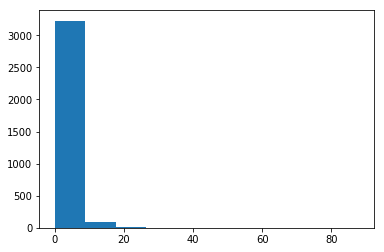

In [27]:
plt.hist(col_sum.tolist()[0])

In [30]:
row_list = [i[0] for i in row_sum.tolist()]

(array([3.227e+03, 8.700e+01, 8.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  8.8, 17.6, 26.4, 35.2, 44. , 52.8, 61.6, 70.4, 79.2, 88. ]),
 <a list of 10 Patch objects>)

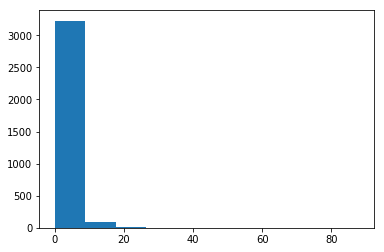

In [32]:
plt.hist(row_list)

In [34]:
emb_df = pd.DataFrame(emb)

In [35]:
emb_df['degree'] = row_list

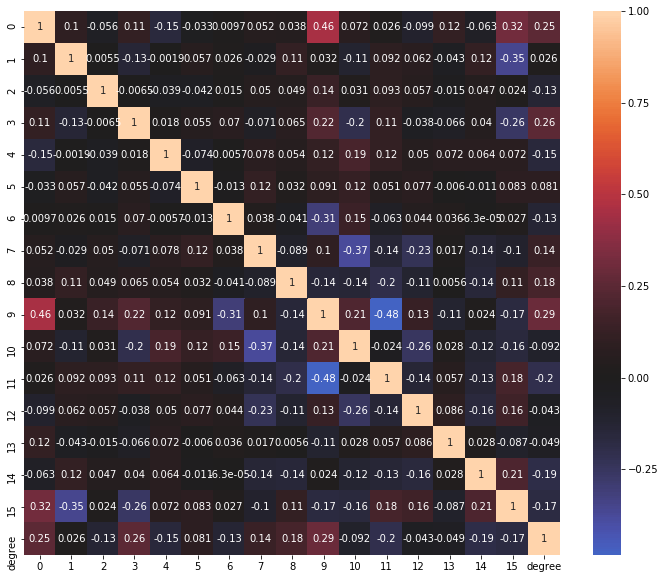

In [50]:
plt.figure(figsize = (12, 10))
sns.heatmap(emb_df.corr(), center=0, annot=True)

In [51]:
emb_df.corr().sort_values('degree')['degree']

11       -0.200872
14       -0.191724
15       -0.170664
4        -0.152419
2        -0.126434
6        -0.126093
10       -0.091699
13       -0.048856
12       -0.043142
1         0.026193
5         0.081186
7         0.140174
8         0.178056
0         0.253327
3         0.255159
9         0.291904
degree    1.000000
Name: degree, dtype: float64

In [36]:
class OptimizerVAE(object):
    def __init__(self, preds, labels, labels2, model, num_nodes, pos_weight, norm):
        preds_sub = preds
        labels_sub = labels
        
        self.cost = norm * tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=preds_sub,
                                                                                   targets=labels_sub,
                                                                                   pos_weight=pos_weight))
        
        
        self.cost += tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits     = preds_sub,
                                                                             targets    = labels2,
                                                                             pos_weight = pos_weight))
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)  # Adam Optimizer

        # Latent loss
        self.log_lik = self.cost
        self.kl = (0.5 / num_nodes) * tf.reduce_mean(tf.reduce_sum(1 + 2 * model.z_log_std -
                                                                   tf.square(model.z_mean) -
                                                                   tf.square(tf.exp(model.z_log_std)), 1))
        self.cost -= self.kl

        self.opt_op = self.optimizer.minimize(self.cost)
        self.grads_vars = self.optimizer.compute_gradients(self.cost)

        self.correct_prediction = tf.equal(tf.cast(tf.greater_equal(tf.sigmoid(preds_sub), 0.5), tf.int32),
                                           tf.cast(labels_sub, tf.int32))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))



In [3]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score


sys.path.append('../')

from optimizer import OptimizerAE, OptimizerVAE
from input_data import load_data
from model import GCNModelAE, GCNModelVAE
from preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges



# Settings

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
#flags.DEFINE_integer('hidden3', 2, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', 'gcn_ae', 'Model string.')
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')
flags.DEFINE_integer('features', 1, 'Whether to use features (1) or not (0).')

flags.DEFINE_string('f', '', 'kernel')

#model_str = FLAGS.model
#dataset_str = FLAGS.dataset

model_str = 'gcn_vae'
dataset_str = 'citeseer'

# Load data
adj, features, ty, y = load_data_2(dataset_str)


# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

# Some preprocessing
adj_norm = preprocess_graph(adj)

# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

num_nodes = adj.shape[0]

features = sparse_to_tuple(features.tocoo())
num_features = features[2][1]
features_nonzero = features[1].shape[0]

# Create model
model = None
if model_str == 'gcn_ae':
    model = GCNModelAE(placeholders, num_features, features_nonzero)
elif model_str == 'gcn_vae':
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

pos_weight = float(features[0].shape[0] * features[0].shape[0] - features[0].sum()) / features[0].sum()

norm = features[0].shape[0] * features[0].shape[0] /\
            float((features[0].shape[0] * features[0].shape[0] - features[0].sum()) * 2)

# Optimizer
with tf.name_scope('optimizer'):

    print('The shape of features placeholder is: %s' % tf.sparse_tensor_to_dense(placeholders['features']).shape)
    
    opt = OptimizerVAE(preds  =  model.reconstructions,
                       labels =  tf.reshape(tf.sparse_tensor_to_dense(placeholders['features'],
                                                                       validate_indices=False), [-1]),
                        model      = model,
                        num_nodes  = num_nodes,
                        pos_weight = pos_weight,
                        norm       = norm)

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

cost_val = []
acc_val = []


def get_roc_score(edges_pos, edges_neg, emb=None):
    
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score, emb, labels_all


cost_val = []
acc_val = []
val_roc_score = []

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    roc_curr, ap_curr, emb, labels_all = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

roc_score, ap_score, emb, labels_all = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))



/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

SparseTensor(indices=Tensor("Placeholder_2:0", shape=(?, ?), dtype=int64), values=Tensor("Placeholder_1:0", shape=(?,), dtype=float32), dense_shape=Tensor("Placeholder:0", shape=(?,), dtype=int64))
The shape of features placeholder is: <unknown>
Instructions for updating:
targets is deprecated, use labels instead

Epoch: 0001 train_loss= 0.44551 train_acc= 0.49996 val_roc= 0.66275 val_ap= 0.65296 time= 4.16093
Epoch: 0002 train_loss= 0.44490 train_acc= 0.51188 val_roc= 0.69627 val_ap= 0.71114 time= 0.73523
Epoch: 0003 train_loss= 0.44187 train_acc= 0.58429 val_roc= 0.69532 val_ap= 0.71594 time= 0.76125
Epoch: 0004 train_loss= 0.43296 train_acc= 0.76063 val_roc= 0.69697 val_ap= 0.71856 time= 0.78843
Epoch: 0005 train_loss= 0.41679 train_acc= 0.92300 val_roc= 0.69411 val_ap= 0.

Epoch: 0063 train_loss= 0.32593 train_acc= 0.99145 val_roc= 0.67467 val_ap= 0.70839 time= 0.67728
Epoch: 0064 train_loss= 0.32589 train_acc= 0.99146 val_roc= 0.67510 val_ap= 0.71015 time= 0.69343
Epoch: 0065 train_loss= 0.32585 train_acc= 0.99146 val_roc= 0.67614 val_ap= 0.71128 time= 0.74233
Epoch: 0066 train_loss= 0.32561 train_acc= 0.99146 val_roc= 0.67704 val_ap= 0.71209 time= 0.65438
Epoch: 0067 train_loss= 0.32545 train_acc= 0.99145 val_roc= 0.67783 val_ap= 0.71618 time= 0.66927
Epoch: 0068 train_loss= 0.32525 train_acc= 0.99145 val_roc= 0.67937 val_ap= 0.71678 time= 0.72044
Epoch: 0069 train_loss= 0.32521 train_acc= 0.99142 val_roc= 0.68163 val_ap= 0.71746 time= 0.67850
Epoch: 0070 train_loss= 0.32501 train_acc= 0.99142 val_roc= 0.68435 val_ap= 0.72047 time= 0.70538
Epoch: 0071 train_loss= 0.32489 train_acc= 0.99140 val_roc= 0.68691 val_ap= 0.71795 time= 0.64596
Epoch: 0072 train_loss= 0.32463 train_acc= 0.99138 val_roc= 0.68845 val_ap= 0.71849 time= 0.63332
Epoch: 0073 train_lo

Epoch: 0147 train_loss= 0.30036 train_acc= 0.97826 val_roc= 0.77183 val_ap= 0.75680 time= 0.77642
Epoch: 0148 train_loss= 0.30000 train_acc= 0.97835 val_roc= 0.77283 val_ap= 0.75824 time= 0.70877
Epoch: 0149 train_loss= 0.29981 train_acc= 0.97790 val_roc= 0.77091 val_ap= 0.75235 time= 0.69431
Epoch: 0150 train_loss= 0.29937 train_acc= 0.97817 val_roc= 0.77050 val_ap= 0.75025 time= 0.70795
Epoch: 0151 train_loss= 0.29907 train_acc= 0.97793 val_roc= 0.77065 val_ap= 0.75022 time= 0.78537
Epoch: 0152 train_loss= 0.29878 train_acc= 0.97728 val_roc= 0.76990 val_ap= 0.74832 time= 0.64079
Epoch: 0153 train_loss= 0.29854 train_acc= 0.97694 val_roc= 0.76718 val_ap= 0.74071 time= 0.78015
Epoch: 0154 train_loss= 0.29831 train_acc= 0.97739 val_roc= 0.76799 val_ap= 0.74123 time= 0.78352
Epoch: 0155 train_loss= 0.29815 train_acc= 0.97602 val_roc= 0.76746 val_ap= 0.74412 time= 0.75228
Epoch: 0156 train_loss= 0.29767 train_acc= 0.97639 val_roc= 0.76566 val_ap= 0.74022 time= 0.73146
Epoch: 0157 train_lo

In [6]:
model.reconstructions

<tf.Tensor 'gcnmodelvae/fullyconnecteddecoder_1/Sigmoid:0' shape=(?,) dtype=float32>

In [8]:
norm

0.5171163393922366

In [9]:
num_nodes

3327

In [10]:
placeholders['adj']

In [11]:
num_features

3703

In [12]:
features

(array([[   0,  184],
        [   0,  257],
        [   0,  362],
        ...,
        [3326, 3472],
        [3326, 3556],
        [3326, 3621]], dtype=int32),
 array([1., 1., 1., ..., 1., 1., 1.]),
 (3327, 3703))

In [6]:
X_embedded = TSNE(n_components=2,  perplexity = 6).fit_transform(emb)
y_onehot = y.todense()
y_list = np.argmax(y_onehot, axis=1)
y_list = [i[0] for i in y_list.tolist()]
conference_labels = ['Agents', 'AI', 'DB', 'IR', 'ML', 'HCI']
plot_labels = [conference_labels[i] for i in y_list]
plot_df = pd.DataFrame({'x0': X_embedded[:,0], 'x1': X_embedded[:,1], 'y': y_list, 'y_label': plot_labels})

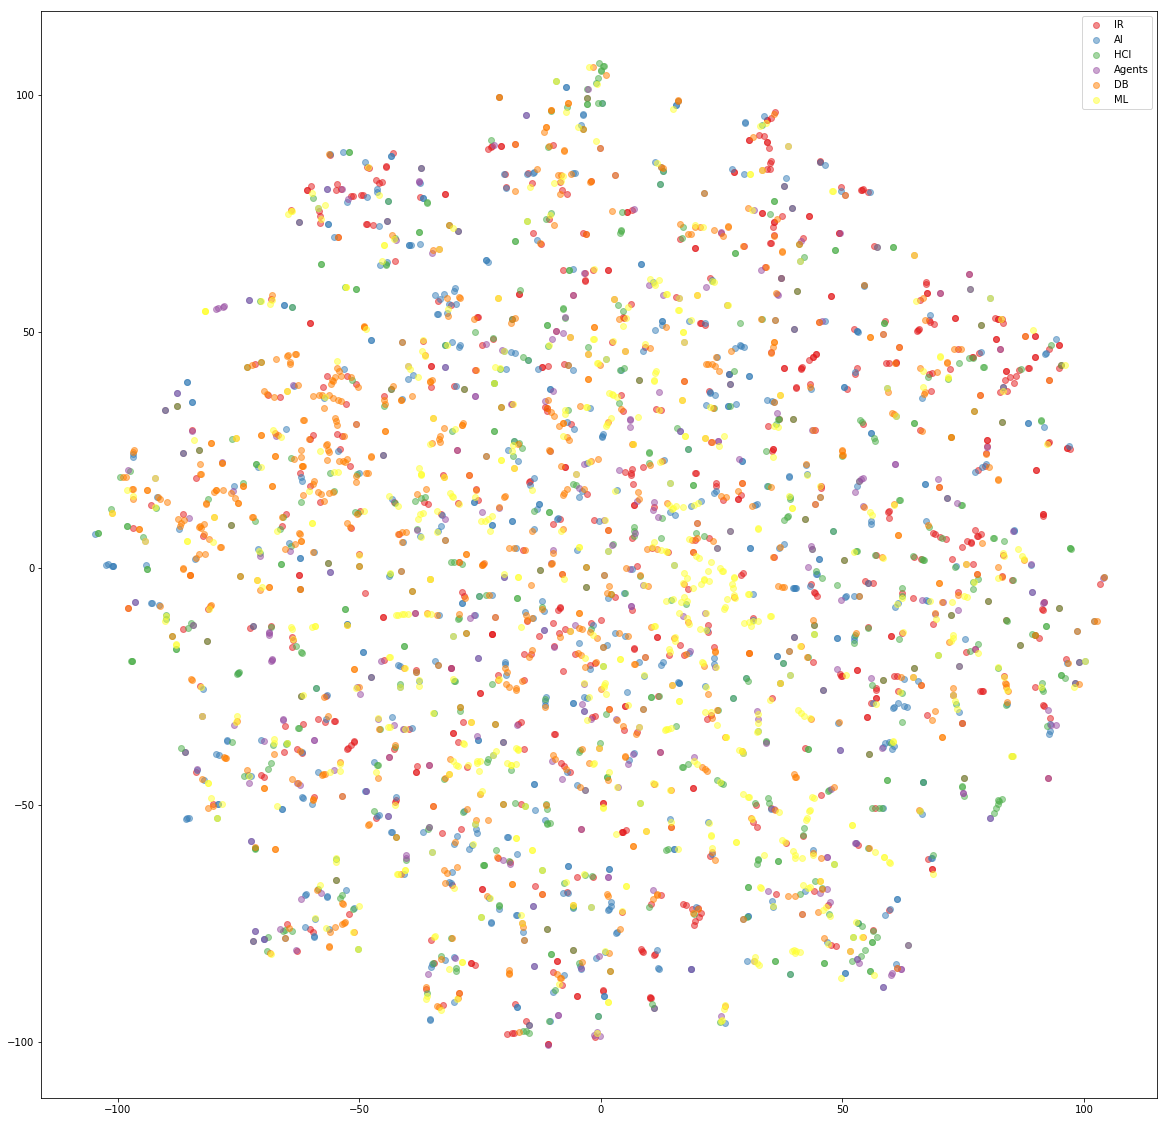

In [7]:
plt.figure(figsize = (20, 20))
colors = plt.cm.get_cmap('Set1').colors

for i, label in enumerate(plot_df['y_label'].unique()):

    colors      = plt.cm.get_cmap('Set1').colors
    plot_df_sub = plot_df.loc[plot_df['y_label'] == label]
    
    plt.scatter(plot_df_sub['x0'], plot_df_sub['x1'], c = matplotlib.colors.to_hex(colors[i]),
                alpha = 0.5, cmap = cm.hsv, label = label)

plt.legend()

In [6]:
plot_df_sub

,x0,x1,y,y_label
11,-7.256630,-75.384026,4,ML
17,59.947292,43.137547,4,ML
18,31.479925,20.788898,4,ML
28,-50.113693,4.263702,4,ML
32,-62.249527,-22.578306,4,ML
...,...,...,...,...
3314,-54.001320,0.885155,4,ML
3317,-42.608353,65.056488,4,ML
3322,-50.744236,8.430223,4,ML
3323,-50.743813,8.431239,4,ML


In [7]:
emb_df = pd.DataFrame(emb)

In [9]:
emb_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,3.756340,4.255910,-0.447281,-3.227427,-0.060793,3.654043,3.242551,-0.946277,3.067766,-1.955020,-0.259375,1.259756,3.662386,3.498413,-1.194281,-3.009324
1,0.322144,6.671773,-2.922417,-2.465346,-0.920210,7.238482,-1.507215,-1.680883,2.079859,-3.622731,-1.283536,1.345398,3.307827,-0.106911,-4.872790,1.242788
2,3.226242,3.894843,3.178463,-0.642581,-2.490225,5.056809,0.858372,-3.071144,0.694309,-5.085511,-2.954876,1.438727,1.350212,1.814381,-5.694824,3.562656
3,2.279464,-2.331634,-2.242826,-6.161113,-1.282453,3.123134,-0.184435,-0.418245,3.680521,-3.990573,2.008558,7.067258,3.678850,5.603893,-8.524942,4.767007
4,2.745486,2.825297,-1.071086,-0.660984,-1.963248,7.323171,-1.472225,2.731857,3.102784,-3.998148,-1.402604,1.926024,2.135146,3.945669,-6.452186,0.616430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,4.628554,1.130685,-2.361838,-3.564151,-5.424749,8.478963,1.050092,1.527564,2.440186,-9.412664,-4.679079,7.388258,-0.085135,6.893012,-4.623759,7.227334
3323,17.132696,-2.955285,-9.669201,-19.506010,-1.904521,9.803341,-3.205849,-3.249812,7.998897,-11.377902,7.761790,17.384460,-0.372769,28.001385,-20.395491,15.651716
3324,2.304747,4.700958,-2.528939,-1.182116,0.400624,4.787477,-0.076485,-0.653543,2.691639,-1.014711,-0.209465,1.865977,2.235720,0.478202,-0.729308,1.996519
3325,9.868710,-0.955921,3.543922,0.186729,-16.529808,7.028476,-5.716125,2.731006,37.687084,-3.263667,-6.314904,-2.882859,33.313511,24.708645,-11.138746,12.193492


In [10]:
adj

<3327x3327 sparse matrix of type '<class 'numpy.float64'>'
	with 7740 stored elements in Compressed Sparse Row format>

In [23]:
emb_df['degree'] = (np.sum(adj, axis = 0).tolist()[0])

In [24]:
emb_df.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,degree
0,1.000000,0.063964,-0.388011,0.020791,0.178874,0.361869,-0.360901,-0.176227,0.582251,-0.359963,-0.184764,0.097486,0.381380,0.001938,0.056102,0.204328,-0.052434
1,0.063964,1.000000,-0.135549,-0.106287,-0.025552,0.114690,-0.362586,-0.488135,0.253386,0.010955,0.024031,-0.045999,0.013251,0.303862,-0.216063,0.476724,0.004561
2,-0.388011,-0.135549,1.000000,-0.034305,-0.001606,-0.030925,0.360802,0.065486,-0.524501,0.270169,-0.032277,-0.216409,-0.272555,0.256066,-0.072120,0.193284,0.026839
3,0.020791,-0.106287,-0.034305,1.000000,-0.208436,-0.355255,0.294505,0.212659,-0.051848,0.224586,0.107900,0.483479,-0.294977,-0.122995,0.530896,-0.330692,0.018500
4,0.178874,-0.025552,-0.001606,-0.208436,1.000000,0.001150,0.017413,-0.032957,-0.068724,-0.215037,-0.333639,-0.431555,0.192187,0.186088,0.029614,0.137889,0.012712
5,0.361869,0.114690,-0.030925,-0.355255,0.001150,1.000000,-0.316714,-0.500247,0.109256,-0.339739,-0.170231,-0.263520,0.523820,0.075530,-0.496753,0.234858,-0.097707
6,-0.360901,-0.362586,0.360802,0.294505,0.017413,-0.316714,1.000000,0.035491,-0.559883,0.313773,0.097519,0.160123,-0.277145,0.130145,0.207773,-0.580151,0.138534
7,-0.176227,-0.488135,0.065486,0.212659,-0.032957,-0.500247,0.035491,1.000000,-0.126190,0.378932,0.261020,0.044245,-0.439273,-0.407188,0.545284,-0.160133,0.115531
8,0.582251,0.253386,-0.524501,-0.051848,-0.068724,0.109256,-0.559883,-0.126190,1.000000,-0.396018,-0.297625,0.066790,0.557492,0.038238,-0.079747,0.217276,-0.047292
9,-0.359963,0.010955,0.270169,0.224586,-0.215037,-0.339739,0.313773,0.378932,-0.396018,1.000000,0.704647,-0.013603,-0.542239,0.055570,0.386240,-0.241625,0.038479


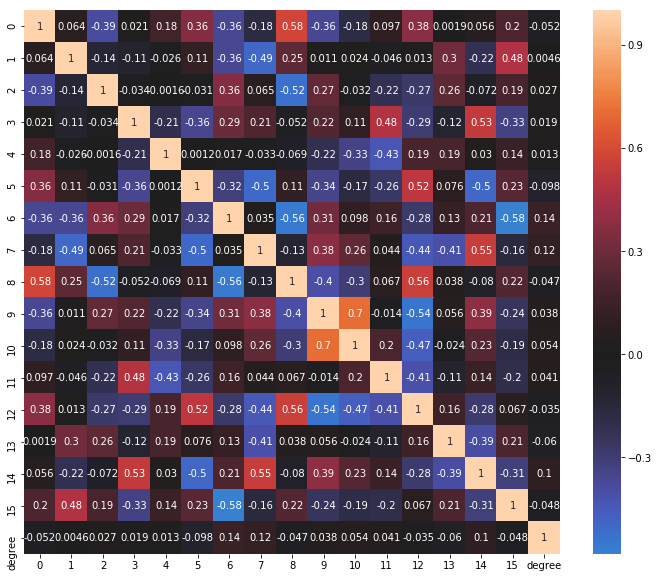

In [25]:
plt.figure(figsize = (12, 10))
sns.heatmap(emb_df.corr(), center=0, annot=True)